In [1]:
#!python3 -m pip install git+https://github.com/UCL/dxh.git

In [2]:
import dolfinx
import dxh
import ufl
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
from petsc4py import PETSc
from scipy.sparse import csr_matrix
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
from petsc4py.PETSc import ScalarType
from GMREs import GMRes, MinRes

Define experiment parameters

In [3]:
final_time = 0.02
number_of_time_slices = 8
number_spatial_mesh_cells = 40
time_step = final_time / number_of_time_slices
include_initial_condition = True
solve_iterative =False
spatial_element_degree = 1
temporal_element_degree = 1
# stabilization parameters
#lambda_nitsche = 5 * spatial_element_degree**2
gamma_0 = 1
gamma_1 = 1
gamma_m = 1
#gamma_primal_jump = gamma_primal
#gamma_dual = 1
#gamma_data = 1

Set up temporal basis functions for trial and test function spaces

Construct mesh on one-dimensional unit interval spatial domain

In [4]:
communicator = MPI.COMM_WORLD
mesh = dolfinx.mesh.create_unit_interval(communicator, number_spatial_mesh_cells)
#mesh = dolfinx.mesh.create_unit_square(communicator, number_spatial_mesh_cells,number_spatial_mesh_cells)

Create base vector finite element with continuous Galerkin family and dimension proportional to number slices temporal interval is split into

In [5]:
# need to implement divergence freeb CR element in basix
vector_element_primal = ufl.VectorElement(
    family="CG",
    cell=mesh.ufl_cell(),
    degree=spatial_element_degree,
    dim= number_of_time_slices+1
)
vector_element_dual = ufl.VectorElement(
    family="CG",
    cell=mesh.ufl_cell(),
    degree=spatial_element_degree,
    dim= number_of_time_slices
)

Create a mixed element corresponding to outer level of nesting for each of two variables ( velocity primal,  velocity dual) and corresponding function space

In [6]:
mixed_element = ufl.MixedElement([vector_element_primal,vector_element_dual ])
mixed_function_space = dolfinx.fem.FunctionSpace(mesh, mixed_element)

Construct trial and test functions for primal and dual variables ( velocity)

In [7]:
(velocity_primal_trial_function,
    velocity_dual_trial_function,
) = ufl.TrialFunctions(mixed_function_space)
(  velocity_primal_test_function,
    velocity_dual_test_function,
) = ufl.TestFunctions(mixed_function_space)
#(
##    velocity_primal_test_function,
#    velocity_dual_test_function_tmp,
#) = ufl.TestFunctions(mixed_function_space)
#velocity_dual_test_function = [0,velocity_dual_test_function_tmp] 

Create indicator function on spatial domain for where data is available

In [8]:
def data_domain_indicator(spatial_coordinate, lower_bound=0.2, upper_bound=0.8):
    # print(~((spatial_coordinate[0] <= lower_bound) | (spatial_coordinate[0] >= upper_bound)) * 1)
    # print((spatial_coordinate[0] >= lower_bound) & (spatial_coordinate[0] <= upper_bound)*1)
    # return ~((spatial_coordinate[0] <= lower_bound) | (spatial_coordinate[0] >= upper_bound)) * 1
    return  ((spatial_coordinate[0] >= lower_bound) & (spatial_coordinate[0] <= upper_bound))*1

indicator_function_space = dolfinx.fem.FunctionSpace(mesh, ("DG", 0))
data_domain_indicator_function = dolfinx.fem.Function(indicator_function_space)
data_domain_indicator_function.interpolate(data_domain_indicator)
# print(data_domain_indicator_function.x.array)


Define function for constructing required measures / integrals on spatial domain and create instances of measures for mesh

In [9]:
def construct_measures(mesh, spatial_element_degree):
    metadata = {"quadrature_degree": 2 * spatial_element_degree + 3}
    cell_integral = ufl.Measure("cell", domain=mesh, metadata=metadata)
    exterior_facet_integral = ufl.Measure("exterior_facet", domain=mesh, metadata=metadata)
    interior_facet_integral = ufl.Measure("interior_facet", domain=mesh, metadata=metadata)
    return cell_integral, exterior_facet_integral, interior_facet_integral



Definition  of $\tau \partial_{\tau}u^n$

In [10]:
def num_par_der(
    velocity_primal_trial_function_current,
    velocity_primal_trial_function_previous   
):
    return velocity_primal_trial_function_current - velocity_primal_trial_function_previous

$A_1(u,w)=\tau \sum^{N}_{n=1}\Bigl(   (\partial_{\tau}u^n,w^n)+a_h(u^n,w^n)\Bigr    )$

In [11]:
def problem_bilinear_form( 
    velocity_primal_trial_function_current,
    velocity_primal_trial_function_previous,
    velocity_dual_test_function,
    time_step,
    mesh,
    spatial_element_degree,
    cell_integral,
):
    # cell_integral, exterior_facet_integral, _ = construct_measures(
    #     mesh, spatial_element_degree
    # )
    # facet_normal = ufl.FacetNormal(mesh)
    return (
        #integral_dphi_phi
         (ufl.inner(
            num_par_der(velocity_primal_trial_function_current, velocity_primal_trial_function_previous),
            velocity_dual_test_function,
        )
        * cell_integral)
        + (time_step
        * ufl.inner(
            ufl.grad(velocity_primal_trial_function_current),
            ufl.grad(velocity_dual_test_function),
        )
        * cell_integral)
     )

$A_{2}((u,z),v)= \gamma_M\tau \sum^{N}_{n=1}(u^n,v^n)_{\omega}+\gamma_0(h \nabla u^0,h \nabla v^0) +\gamma_1 \tau\sum^{N}_{n=1}(\tau \nabla \partial_{\tau}u^n, \tau \nabla \partial_{\tau}v^n) +\tau\sum^{N}_{n=1}\sum_{F \in \mathcal{F}_h}\frac{1}{h}(\mathcal{J}(u^n),\mathcal{J}({v^n}))_F+\tau \sum^{N}_{n=1}((\partial_{\tau}v^n,z^n)+a_h(v^n,z^n))$

$A_{2}((u,z),v)-\gamma_0(h \nabla u^0,h \nabla v^0)$, 

In [12]:
def primal_stabilizer_bilinear_form(
    velocity_primal_trial_function_current,
    velocity_primal_trial_function_previous,
    velocity_primal_test_function_current,
    velocity_primal_test_function_previous,
    velocity_dual_trial_function,
    time_step,
    mesh,
    spatial_element_degree,
    gamma_0,
    gamma_1,
    gamma_m,
    cell_integral,
    interior_facet_integral,
    cell_diameter,
):
    # (
    #     cell_integral,
    #     exterior_facet_integral,
    #     interior_facet_integral
    # ) = construct_measures(mesh, spatial_element_degree)
    # cell_diameter = ufl.CellDiameter(mesh)
    return (
        (gamma_m
        * time_step
        * data_domain_indicator_function
        * ufl.inner(
                    velocity_primal_trial_function_current,
                    velocity_primal_test_function_current,
                )
        * cell_integral)
        #gamma_1 term
        + (gamma_1
        * time_step
        * ufl.inner(
             ufl.grad(num_par_der(velocity_primal_trial_function_current, velocity_primal_trial_function_previous)),
            ufl.grad(num_par_der(velocity_primal_test_function_current, velocity_primal_test_function_previous)),
        )
        * cell_integral)
        # jump term
        + (time_step
        * (1 / (0.5*(cell_diameter('+')+cell_diameter('-'))))
           * ufl.inner(ufl.jump(velocity_primal_trial_function_current),ufl.jump(velocity_primal_test_function_current))
        * interior_facet_integral)
        #+ integral_dphi_phi
        + (ufl.inner(
            num_par_der(velocity_primal_test_function_current, velocity_primal_test_function_previous),
            velocity_dual_trial_function,
        )
        * cell_integral)
        + (time_step
        #* integral_phi_phi
        * ufl.inner(
            ufl.grad(velocity_primal_test_function_current),
            ufl.grad(velocity_dual_trial_function),
        )
        * cell_integral)
         
    )

In [13]:
def sample_sol(t,xu):
    #return ufl.cos(ufl.pi*(t))*ufl.sin(ufl.pi*xu[0])
    return ufl.exp(-4*ufl.pi**2*(t))*ufl.sin(2*ufl.pi*xu[0])

In [14]:
def sample_sol_np(t,xu):
    #return np.cos(np.pi*(t))*np.sin(np.pi*xu[0])
    return np.exp(-4*np.pi**2*(t))*np.sin(2*ufl.pi*xu[0])

In [15]:
def rhs(t,xu):
    #return (-ufl.pi*ufl.sin(ufl.pi*t)+ufl.pi**2*ufl.cos(ufl.pi*t))*ufl.sin(ufl.pi*xu[0])
    return dolfinx.fem.Constant(mesh, ScalarType(0))

Wellposed $\text{Bilinear}+\int_{\Omega}u^0v^0 \,dx$, 
Ill-Posed $\text{Bilinear}+ \gamma_0 h^2\int_{\Omega}\nabla u^0 \nabla v^0 \,dx$

In [16]:
cell_diameter = ufl.CellDiameter(mesh)
spatial_coordinate = ufl.SpatialCoordinate(mesh)
cell_integral,exterior_facet_integral,interior_facet_integral = construct_measures(mesh, spatial_element_degree)

if include_initial_condition:
    bilinear_form = ufl.inner(velocity_primal_trial_function[0], velocity_primal_test_function[0]) * cell_integral
else:
    bilinear_form = gamma_0 * cell_diameter**2 * ufl.inner(ufl.grad(velocity_primal_trial_function[0]),
                                             ufl.grad(velocity_primal_test_function[0])) * cell_integral
linear_form = 0   # Krishna: should we replace it with vector zero

for time_slice_index in range(1,number_of_time_slices+1):
    time_slice = time_slice_index * time_step
    # A_1[primal_trial, primal_test]
    bilinear_form += problem_bilinear_form(
        velocity_primal_trial_function[time_slice_index],
        velocity_primal_trial_function[time_slice_index-1],
        velocity_dual_test_function[time_slice_index-1],  # Krishna: time slice index current or previous?
        time_step,
        mesh,
        spatial_element_degree,
        cell_integral,
    )
    # A_2[(primal_trial, dual_trial), primal_test]
    bilinear_form += primal_stabilizer_bilinear_form(
        velocity_primal_trial_function[time_slice_index],
        velocity_primal_trial_function[time_slice_index-1],
        velocity_primal_test_function[time_slice_index],
        velocity_primal_test_function[time_slice_index-1],
        velocity_dual_trial_function[time_slice_index-1], # Krishna: time slice index current or previous?
        time_step,
        mesh,
        spatial_element_degree,
        gamma_0,
        gamma_1,
        gamma_m,
        cell_integral,
        interior_facet_integral,
        cell_diameter,
    )
    f=rhs(time_slice,spatial_coordinate)
    q=sample_sol(time_slice,spatial_coordinate)
    linear_form += (
        (time_step * f * velocity_dual_test_function[time_slice_index-1] * cell_integral)
                    + (time_step * gamma_m * data_domain_indicator_function * q * velocity_primal_test_function[time_slice_index] * cell_integral)
    )

if include_initial_condition:
    linear_form += sample_sol(0.0,spatial_coordinate) * velocity_primal_test_function[0] * cell_integral
    
# for time_slice_index in range(0,number_of_time_slices+1):
#     pass

    #if time_slice_index < number_of_time_slices: 
    #    bilinear_form += 1e-5 * ufl.inner(ufl.grad(velocity_dual_trial_function[time_slice_index]),
     #  ufl.grad(velocity_dual_test_function[time_slice_index])) * cell_integral
    
    
    #bilinear_form += 1e-11 * ufl.inner(ufl.grad(velocity_primal_trial_function[time_slice_index]),
    #                                 ufl.grad(velocity_primal_test_function[time_slice_index])) * cell_integral
    #if time_slice_index < number_of_time_slices:
    #if time_slice_index < number_of_time_slices: 
    #       bilinear_form += 1e-11 * ufl.inner(velocity_primal_trial_function[time_slice_index],
    #                                  velocity_dual_test_function[time_slice_index]) * cell_integral
    #bilinear_form += 1e-11 * ufl.inner(velocity_primal_test_function[time_slice_index],
    #                                  velocity_dual_trial_function[time_slice_index]) * cell_integral


Assemble matrix for bilinear form (left-hand side of linear system)

In [17]:
#W0,W0_to_VW = primal_dual_function_space.sub(1).collapse()
bc_function = dolfinx.fem.Function(mixed_function_space)
bc_function.x.array[:] = 0.0
tdim = mesh.topology.dim
fdim = tdim - 1 # Krishna: why  ?
mesh.topology.create_connectivity(fdim, tdim)
boundary_facets = dolfinx.mesh.exterior_facet_indices(mesh.topology)
boundary_dofs = dolfinx.fem.locate_dofs_topological( mixed_function_space, fdim, boundary_facets)
bc_list = [dolfinx.fem.dirichletbc(bc_function, boundary_dofs)]
#print(boundary_dofs)

In [18]:
# type(bc)

In [19]:
dolfinx_bilinear_form = dolfinx.fem.form(bilinear_form)
bilinear_form_matrix = dolfinx.fem.petsc.assemble_matrix(dolfinx_bilinear_form, bcs=bc_list)
bilinear_form_matrix.assemble()

Set up solver

Assemble vector for linear form (right-hand side of linear system)

In [20]:
dolfinx_linear_form = dolfinx.fem.form(linear_form)
linear_form_vector = dolfinx.fem.petsc.create_vector(dolfinx_linear_form)
dolfinx.fem.petsc.assemble_vector(linear_form_vector, dolfinx_linear_form);

Solve system and extract solution components for displacement / velocity primal / dual variables

In [21]:
# problem = dolfinx.fem.petsc.LinearProblem(bilinear_form, linear_form, bcs=bc_list, petsc_options={"ksp_type": "cg", "ksp_rtol":1e-6, "ksp_atol":1e-10, "ksp_max_it": 1000})
problem = dolfinx.fem.petsc.LinearProblem(bilinear_form, linear_form, bcs=bc_list, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

solution = problem.solve()


In [22]:
# solution = dolfinx.fem.Function(mixed_function_space)
# if solve_iterative: 
#     def pre(x,y):
#         x.copy(y)
#     u_sol,res = MinRes(bilinear_form_matrix,
#                   linear_form_vector,
#                   pre=pre,
#                   maxsteps = 100000, 
#                   tol = 1e-7, 
#                    #tol = 1e-4,
#                   printrates = False)
    
#     solution.x.array[:] = u_sol.array[:]
#     solution.x.scatter_forward()
    
# else:  
#     print("Solve using direct solver")
#     solver = PETSc.KSP().create(mesh.comm)
#     #solver = PETSc.KSP().create()
#     solver.setOperators(bilinear_form_matrix)
#     solver.setType(PETSc.KSP.Type.PREONLY)
#     solver.getPC().setType(PETSc.PC.Type.LU)
#     solver.solve(linear_form_vector, solution.vector)
#     solution.x.scatter_forward()

(
    velocity_primal_solution,
    velocity_dual_solution
) = solution.split()

#np.any(np.isinf(velocity_primal_solution.x.array))
#np.any(np.isinf(velocity_dual_solution.x.array))

print( len(solution.x.array ) ) 
print(bilinear_form_matrix.getSize())

697
(697, 697)


In [23]:
type(bilinear_form)

ufl.form.Form

In [24]:
# problem = dolfinx.fem.petsc.LinearProblem(bilinear_form, linear_form, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
# uh = problem.solve()

In [25]:
# help(dolfinx.fem.petsc.LinearProblem)

In [26]:
# # print(velocity_primal_solution.x.array)
# print(velocity_dual_solution.x.array)

In [27]:
#u_sol.array

In [28]:
#len(solution.x.array)

In [29]:
#velocity_primal_solution.x.array

In [30]:
#%%timeit
#solver.solve(linear_form_vector, solution.vector)

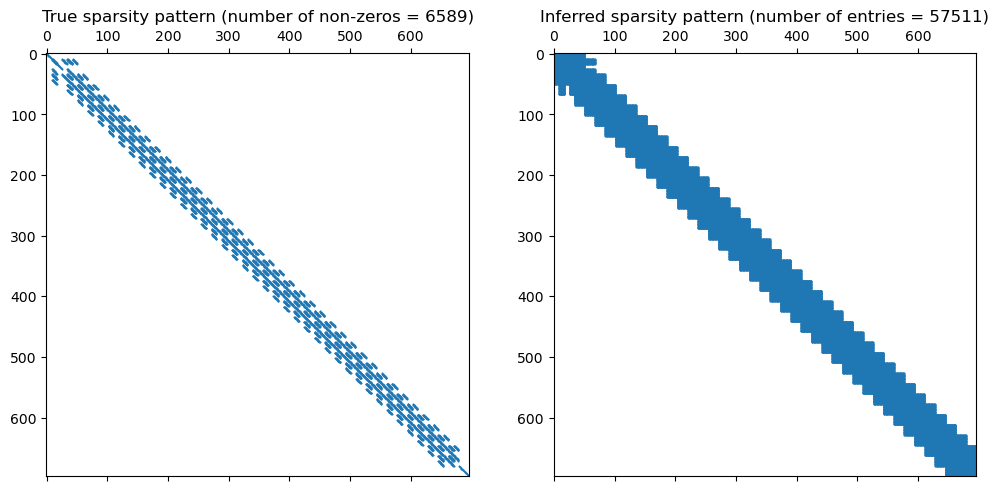

In [31]:
bilinear_form_csr_matrix = csr_matrix(bilinear_form_matrix.getValuesCSR()[::-1])
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].spy(bilinear_form_csr_matrix, markersize=0.5)
axes[0].set_title(f"True sparsity pattern (number of non-zeros = {bilinear_form_csr_matrix.count_nonzero()})")
axes[1].spy(bilinear_form_csr_matrix, markersize=0.5, precision="present")
axes[1].set_title(f"Inferred sparsity pattern (number of entries = {bilinear_form_csr_matrix.nnz})");

In [32]:
A_numpy = bilinear_form_csr_matrix.todense() 
np.linalg.cond(A_numpy)
#eigenvalues, eigenvectors = np.linalg.eig(A_numpy)
#eigenvalues 

617.4502201632514

Extract solution at final time

In [33]:
final_velocity_function_space, dofmap_final_velocity_to_mixed = mixed_function_space.sub(0).sub( number_of_time_slices ).collapse()
final_velocity = dolfinx.fem.Function(final_velocity_function_space)
final_velocity.x.array[:] = velocity_primal_solution.x.array[dofmap_final_velocity_to_mixed] 

final_velocity_dual_function_space, dofmap_final_dual_velocity_to_mixed_dual = mixed_function_space.sub(1).sub( number_of_time_slices -1 ).collapse()
final_velocity_dual = dolfinx.fem.Function(final_velocity_dual_function_space)
final_velocity_dual.x.array[:] = velocity_dual_solution.x.array[dofmap_final_dual_velocity_to_mixed_dual] 

In [34]:
np.any(np.isinf(final_velocity.x.array))

True

In [35]:
#final_velocity.x.array

In [36]:
#final_velocity_dual.x.array

Compute L2 error of numerical solution compared to exact

In [37]:
# measuring error 
exact_velocity_solution =sample_sol(final_time,spatial_coordinate) 
l2_error_squared_form = dolfinx.fem.form(
    ufl.inner(
        final_velocity - exact_velocity_solution, 
        final_velocity - exact_velocity_solution
    ) * cell_integral
)
l2_error_squared_local = dolfinx.fem.assemble_scalar(l2_error_squared_form)
l2_error_global = np.sqrt(mesh.comm.allreduce(l2_error_squared_local, op=MPI.SUM))
print(f"t = {final_time}, L2 error = {l2_error_global} ")

t = 0.02, L2 error = inf 


In [38]:
# measuring error 
#exact_velocity_solution =sample_sol(final_time,spatial_coordinate) 
l2_error_squared_form = dolfinx.fem.form(
    ufl.inner(
        final_velocity_dual, 
        final_velocity_dual
    ) * cell_integral
)
l2_error_squared_local = dolfinx.fem.assemble_scalar(l2_error_squared_form)
l2_error_global = np.sqrt(mesh.comm.allreduce(l2_error_squared_local, op=MPI.SUM))
print(f"t = {final_time}, dual L2 = {l2_error_global} ")

t = 0.02, dual L2 = inf 


In [39]:
velocity_exact = dolfinx.fem.Function(final_velocity_function_space)
velocity_exact.interpolate(lambda x: sample_sol_np(final_time,x))

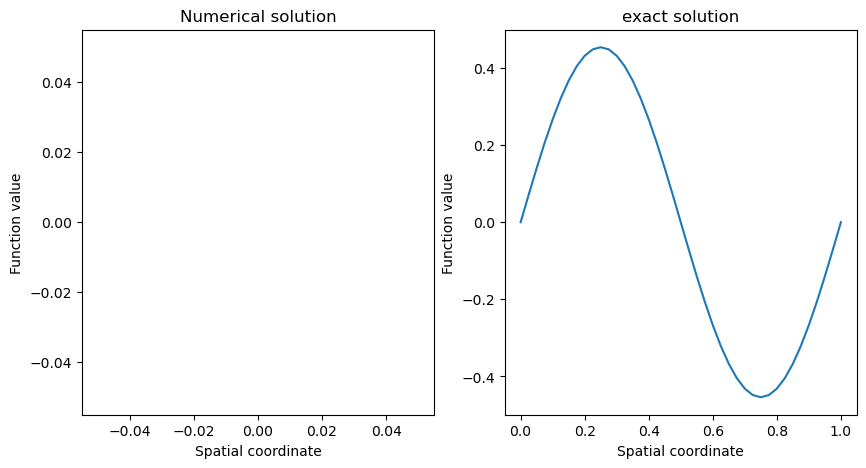

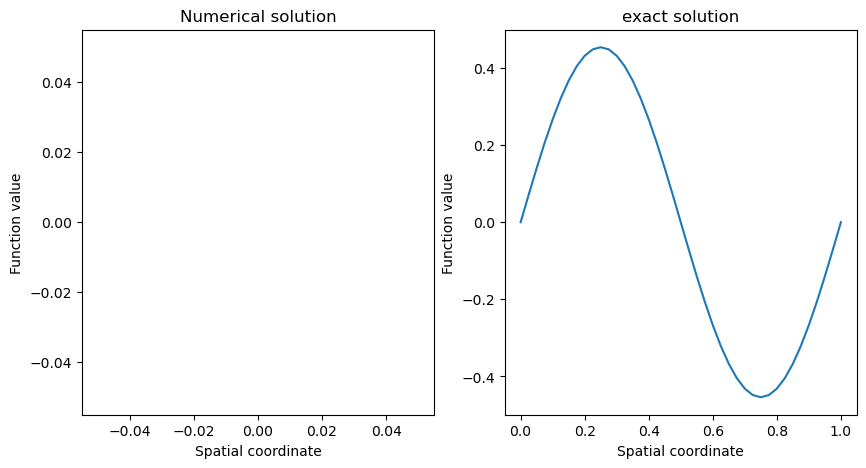

In [40]:
dxh.plot_1d_functions({"Numerical solution": final_velocity,"exact solution": velocity_exact } )